### **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import kmapper as km
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import dyneusr as dsr

from mapping import MappingTDA
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, f1_score

In [2]:
# Set seed for reproducibility
seed_value = 42

# Ignore warnings
warnings.filterwarnings("ignore")

### **Load data**

In [3]:
data_path = 'your data directory here'

x = pd.read_csv(data_path + 'x_file_name.csv')
y = pd.read_csv(data_path + 'sex_labels.csv')

# Print dimensions
print(f'X shape: {x.shape}') # (n_samples, n_features)

X shape: (1109, 52)


Split into train and test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed_value)

# Reset indices
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Print dimensions
print(f'X_train shape: {x_train.shape}')
print(f'X_test shape: {x_test.shape}')

X_train shape: (887, 52)
X_test shape: (222, 52)


#### **Explanatory data analysis**

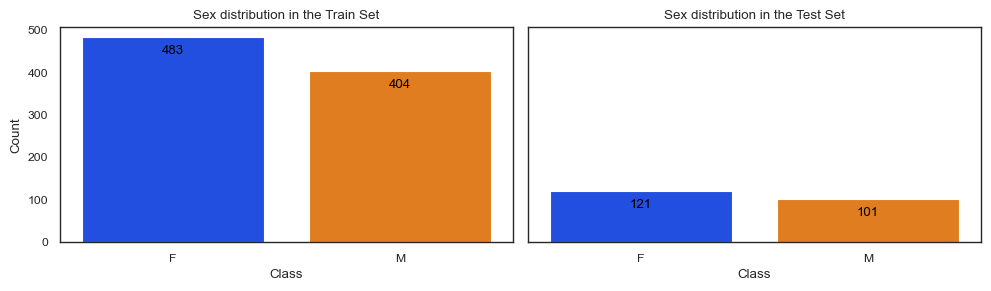

In [5]:
# Define a consistent color palette
unique_classes = sorted(set(y_train['Gender']).union(set(y_test['Gender'])))
palette = sns.color_palette("bright", len(unique_classes))
color_mapping = dict(zip(unique_classes, palette))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Plot the count plot for y_train
ax1 = sns.countplot(ax=axes[0], x=y_train['Gender'], palette=color_mapping.values())
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Sex distribution in the Train Set')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, -10), 
                 textcoords='offset points', color='black')

# Plot the count plot for y_test
ax2 = sns.countplot(ax=axes[1], x=y_test['Gender'], palette=color_mapping.values())
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Sex distribution in the Test Set')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, -10), 
                 textcoords='offset points', color='black')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### **Mapper (TDA)**

In [6]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper()


Choose Filter dimensionality reduction technique

In [7]:
projector = 'isomap'
if projector == 'pca':
    projector = PCA(n_components=2, random_state=seed_value)
elif projector == 'kpca':
    projector = KernelPCA(n_components=2, kernel='rbf', random_state=seed_value)
elif projector == 'isomap':
    projector = Isomap(n_components=2)

lens = projector.fit_transform(x_train)

Choose Cover parameters

In [8]:
cover = km.Cover(n_cubes=20, perc_overlap=0.6)

Choose Clustering technique

In [9]:
min_samples = 3
clusterer = DBSCAN(eps=32, min_samples=min_samples)

Create graph and convert it to NetworkX format

In [10]:
graph = mapper.map(lens, x_train,
                   cover=cover,
                   clusterer=clusterer)

nx_graph = km.adapter.to_nx(graph)

Mapping on data shaped (887, 52) using lens shaped (887, 2)

Creating 400 hypercubes.

Created 2136 edges and 240 nodes in 0:00:00.179504.


Visualize graph

In [ ]:
mapper.visualize(graph=graph, path_html='graph.html')

dyneugraph = dsr.DyNeuGraph(G=graph, y=y_train)
dyneugraph.visualize('graph_dyneusr.html', show=False)

### **Sex distributions across nodes**

In [13]:
def majority_voting(labels):
    # Count the occurrences of each class
    label_counts = Counter(labels)
    
    # Determine the majority class
    majority_class, majority_count = label_counts.most_common(1)[0]
    
    # Calculate the probability of the majority class
    total_count = len(labels)
    probability = majority_count / total_count
    
    return majority_class, probability


In [14]:
graph_nodes = {name: attributes['membership'] for name, attributes in list(nx_graph.nodes(data=True))}

sex_nodes = {}
for node, members in graph_nodes.items():
    sex_distribution = []
    for member in members:
        sex_distribution.append(y_train.loc[member].values[0])

    node_id = int(node.split('cube')[1].split('_')[0])

    majority_sex = majority_voting(sex_distribution)[0]

    sex_distribution = np.array(sex_distribution)
    node_sex_ratio = np.count_nonzero(sex_distribution[sex_distribution==majority_sex])/len(sex_distribution)

    sex_nodes[node_id] = [majority_sex, node_sex_ratio]

Distribution of sex in training set

In [15]:
train_membership = {}
for j in range(0, x_train.shape[0]):
    node_ = []
    for node, members in graph_nodes.items():
        node_id = int(node.split('cube')[1].split('_')[0])
        if j in members:
            node_.append(node_id)
    
    if len(node_) > 0:
        train_membership[j] = node_
    else:
        continue

In [16]:
train_sex_distribution = {}
for idx, nodes in train_membership.items():
    sex_in_nodes = []
    for node in nodes:
        sex_in_nodes.append(sex_nodes[node][0])

    # Majority voting 
    train_sex_distribution[idx] = [majority_voting(sex_in_nodes)[0], y_train.loc[idx].values[0], majority_voting(sex_in_nodes)[1]]

Ratio of sex distribution across nodes

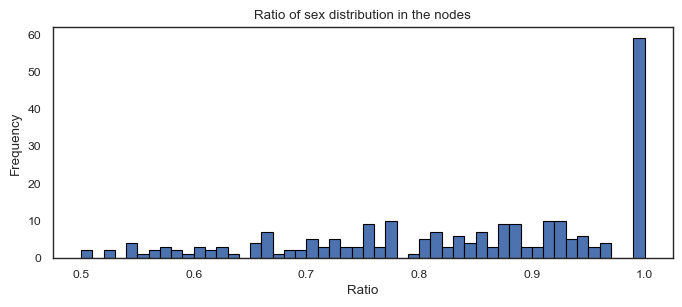

In [17]:
ratios = [value[1] for value in sex_nodes.values()]

# Plot the distribution
plt.figure(figsize=(8, 3))
plt.hist(ratios, bins=50, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.title('Ratio of sex distribution in the nodes')
plt.grid(False)
plt.show()

### **Mapping framework application**

In [18]:
mapping = MappingTDA(x_train, projector, cover)

In [19]:
graph_nodes_idx = [int(el_pca.split('cube')[1].split('_')[0]) for el_pca in list(nx_graph.nodes())]

In [20]:
test_mapped = {}
for i in range(0, x_test.shape[0]):
    subj = x_test.iloc[[i]]
    subj_projected = projector.transform(subj)

    hypercubes_idx, hypercubes, bins = mapping.mapping(subj_projected)

    nodes_idx = []
    for idx in hypercubes_idx:
        if idx in graph_nodes_idx:
            nodes_idx.append(idx)

    test_mapped[i] = nodes_idx

In [21]:
test_sex_distribution = {}
for idx, nodes in test_mapped.items():
    sex_in_nodes = []
    for node in nodes:
        sex_in_nodes.append(sex_nodes[node][0])

    # Majority voting for sex prediction
    test_sex_distribution[idx] = [majority_voting(sex_in_nodes)[0], y_test.loc[idx].values[0], majority_voting(sex_in_nodes)[1]]

Check for predictability

In [22]:
train_results = []
for idx, sex in train_sex_distribution.items():
    if sex[0] == sex[1]:
        train_results.append(1)
    else:
        train_results.append(0)

In [23]:
test_results = []
for idx, sex in test_sex_distribution.items():
    if sex[0] == sex[1]:
        test_results.append(1)
    else:
        test_results.append(0)

In [24]:
accuracy_train = sum(train_results) / len(train_results)
accuracy_test = sum(test_results) / len(test_results)

print(f'Train accuracy: {accuracy_train}')
print(f'Test accuracy: {accuracy_test}')

Train accuracy: 0.7988700564971751
Test accuracy: 0.7387387387387387


In [25]:
y_train_df = pd.DataFrame(train_sex_distribution).T
y_test_df = pd.DataFrame(test_sex_distribution).T

y_train_df.columns = ['Predicted', 'True', 'Prob']
y_test_df.columns = ['Predicted', 'True', 'Prob']

In [26]:
print(classification_report(y_train_df['True'], y_train_df['Predicted'], digits=3))

# Convert the labels to binary
y_train_df['True'] = y_train_df['True'].apply(lambda x: 1 if x == 'M' else 0)
y_train_df['Predicted'] = y_train_df['Predicted'].apply(lambda x: 1 if x == 'M' else 0)
print(f1_score(y_train_df['True'], y_train_df['Predicted'], average='weighted'))

              precision    recall  f1-score   support

           F      0.776     0.888     0.828       483
           M      0.837     0.692     0.757       402

    accuracy                          0.799       885
   macro avg      0.807     0.790     0.793       885
weighted avg      0.804     0.799     0.796       885

0.7960743221399943


In [27]:
print(classification_report(y_test_df['True'], y_test_df['Predicted'], digits=3))

# Convert the labels to binary
y_test_df['True'] = y_test_df['True'].apply(lambda x: 1 if x == 'M' else 0)
y_test_df['Predicted'] = y_test_df['Predicted'].apply(lambda x: 1 if x == 'M' else 0)
print(f1_score(y_test_df['True'], y_test_df['Predicted'], average='weighted'))

              precision    recall  f1-score   support

           F      0.730     0.826     0.775       121
           M      0.753     0.634     0.688       101

    accuracy                          0.739       222
   macro avg      0.741     0.730     0.732       222
weighted avg      0.740     0.739     0.736       222

0.7356028196238249
